# Titanic: Machine Learning from Disaster

## Introduction

$Description$: The Titanic disaster was one of the biggest disaster in the history of ship travel. From kaggle competition (https://www.kaggle.com/c/titanic) we have a lot of information about people in the ship deck. My aim will be forecast who will survive and who unfortunately not. This is a classification task so I use many of machine learning models to create the best one wihich answer the question: Who survived from this disaster ?

### Libraries

In [277]:
import pandas as pd
import numpy as np
from numpy import char
from matplotlib import pyplot as plt
import seaborn as sns

In [278]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sub = pd.read_csv("../data/gender_submission.csv")

Table of Contents
```
1. Exploratory Data Analysis (EDA)
    1.1 Survived 
    1.2 Sex
    1.3 Age
    1.4 Pclass
    1.5 SibSp
    1.6 Parch
    1.7 Ticket
    1.8 Fare
    1.9 Cabin
    1.10 Embarked
    1.11 Name
2. Feature Engineering
    2.1 Creating new features
    2.1 Train test split
    2.2 Imputation
    2.3 One Hot Encoding
3. Modeling
    3.1 Logistic Regression
    3.2 Random Forest
    3.3 Ensemble model
    3.4 Adaboost
    3.5 XGBoost
```

## Exploratory Data Analysis (EDA)

EDA methodology is one of the most important thing during creating machine learning models. If we don't know the data we can't create accurate model. Usually during this step we find out that in some reason one of the feature or only part of some feature is more important than another. For example, in titanic disaster we can think that sex variable will be very important in our model because we know (from the internet, movie) that women had the priority to enter the lifeboat - in effect, if particular person was female then had higher probability that survive in contrast to to male person.

In [279]:
df_train.head(1)

PassengerId  Survived  Pclass                     Name   Sex   Age  SibSp  \
0            1         0       3  Braund, Mr. Owen Harris  male  22.0      1   

   Parch     Ticket  Fare Cabin Embarked  
0      0  A/5 21171  7.25   NaN        S

In [280]:
df_test.head(1)

PassengerId  Pclass              Name   Sex   Age  SibSp  Parch  Ticket  \
0          892       3  Kelly, Mr. James  male  34.5      0      0  330911   

     Fare Cabin Embarked  
0  7.8292   NaN        Q

In [281]:
df_sub.head(1)

PassengerId  Survived
0          892         0

We have 10 columns - without Survived target and PassengerId - index column. Let's check what are the types of them.

In [282]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Half of my features are numeric - Pclass, Age, SibSp, Parch, Fare. In my opinion Pclass, SibSp and Parch aren't numerical features - it will be better for model to convert it to categorical variables. The best for me is to create function for those calculation, because I wil have to repeat that things later on testing dataset. I will do it on Feature Engineering part.

In [283]:
print("Shape of train dataset: ", df_train.shape)
print("Shape of test dataset: ", df_test.shape)
print("Shape of sub dataset: ", df_sub.shape)

Shape of train dataset:  (891, 12)
Shape of test dataset:  (418, 11)
Shape of sub dataset:  (418, 2)


In [284]:
#### Packages options
def pyplot_options(width, length):
    plt.figure(figsize = (width, length))

In [285]:
sns.set(style="ticks", color_codes=True)

#### Target: Survived

Below I create countplot to show that unfortunately in Titanic disaster died more people than survived. We see that both of dataset have the same balanced class. Its not 50/50 but about 62.5%/37.5% in not survived to survivied people but I think that model should deal with that balanced group.

Text(0.5, 1.0, 'Number of survivors of the Titanic disaster')

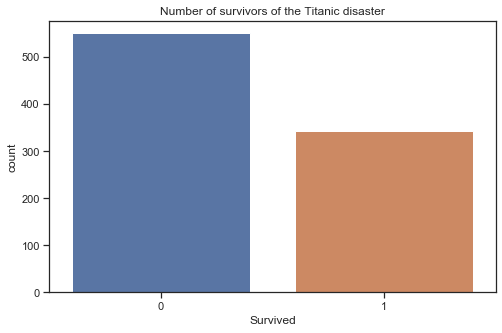

In [286]:
pyplot_options(8, 5)
sns.countplot(x="Survived", data = df_train)
plt.title("Number of survivors of the Titanic disaster")

#### Quick introduce to the dataset

Nice way to quick introduce to the data is to create pairplot. This is the plots where you can see many of the relationships in your dataset in contrast to your target variable - in our case is of course survived variable.

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

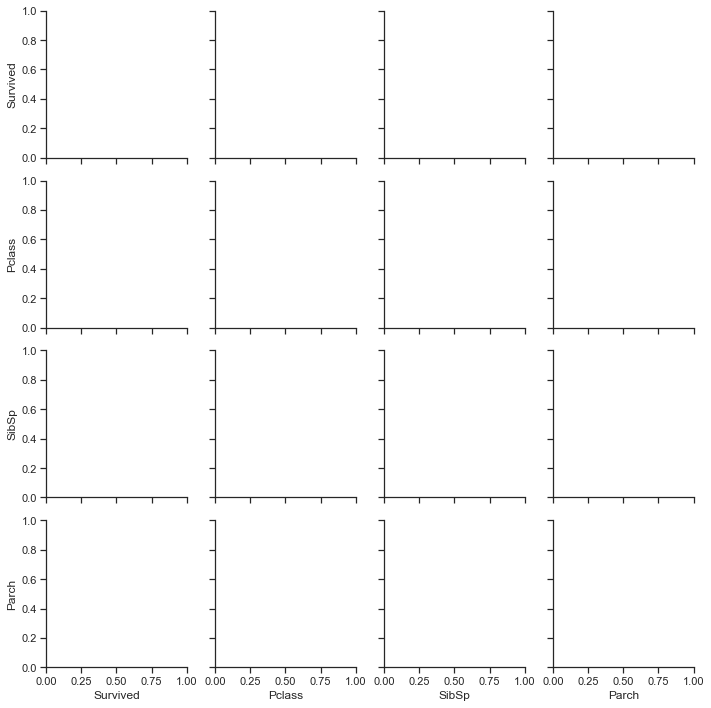

In [289]:
pair_plot_features = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare']
g = sns.pairplot(data=df_train.loc[:, pair_plot_features], hue='Survived', palette = 'husl')

Quick conclusions:
    1. People who pay for ticket not much money (may be they were from crew and pay 0) died more often than 
    rest of passengers
    2. People from lowest class died more often that people from highest class,
    3. People who pay not much money for ticket and were older have higher probability of died,
    4. Alone people (without any of parents or children on ship) died rarely than rest

Of course its only a few conclusions from this pair plot. May be they aren't good and will be not helpful but right now they are interesting for me and compatible with intuition.

#### Feature: Sex

Everything I will be doing on new dataset - df_train_new. The reason is only one. Here I would like to create new features, analyze them and understand my data. During that things I create new functions which will influence on df_train dataset. This functions I will test on df_train_new. After that part of analysis I will create the classification model and then split df_train into train and test set. Then I will use my function on train dataset and create the model. Then I will use this function on test dataset and chceck the performence of model. The last part will be find performence od submission from this competition.

In [290]:
df_train_new = df_train.copy()
df_train_new['Sex'] = df_train_new.Sex.map({'male':1, 'female':0})
df_train_new['Sex'] = df_train_new['Sex'].astype('category')

Text(0.5, 1.0, 'Number of Male and Female people survived from disaster')

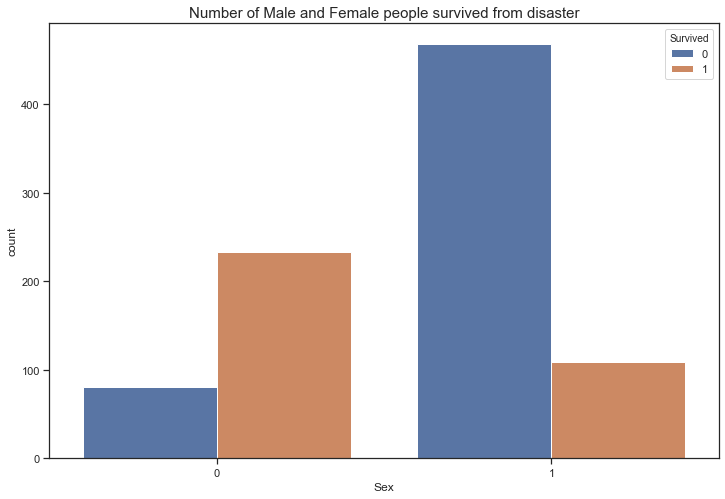

In [291]:
pyplot_options(12, 8)
sns.countplot(data=df_train_new, x='Sex', hue = "Survived")
plt.title("Number of Male and Female people survived from disaster", fontsize=15)

In [293]:
df_train.Sex.isnull().value_counts()

False    891
Name: Sex, dtype: int64

Conclusion: Like I wrote before - women have higher probabilites of survied than men.

#### Feature: Age

Text(0.5, 1.0, 'Number of survivors in contrast to Age variable')

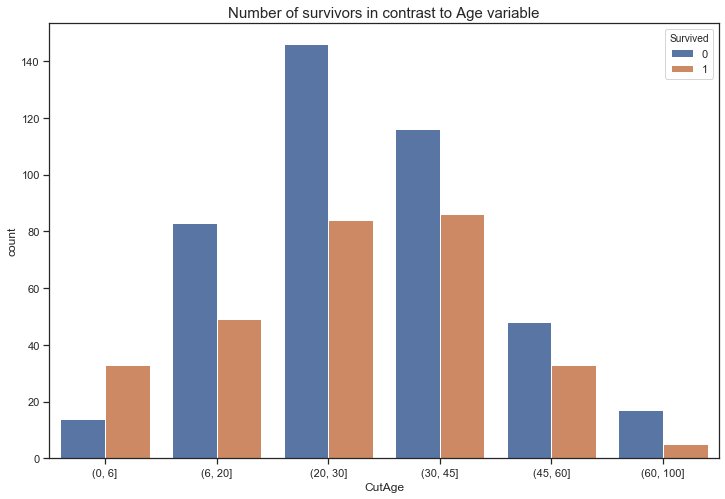

In [292]:
pyplot_options(12, 8)
age_cut=pd.cut(df_train_new.Age, bins = [0, 6, 20, 30, 45, 60, 100])
d = {"CutAge":age_cut, "Survived": df_train_new.Survived}
age_df = pd.DataFrame(data=d)
sns.countplot(data=age_df, x = "CutAge", hue = "Survived")
plt.title("Number of survivors in contrast to Age variable", fontsize = 15)

Conclusion: Age feature should have a big influence to accuracy of our model. We see that for examlpe on medium age like 6-30 survived people have similar balance like all of people about 27.5%/62.5% (like I write at the beginning). Difference behaviour we see for age 0-6 where we see that kids in that age have highest probability of survived about 70%/30%. Different proportion have also ages 60-100 where that people have lowest probability of survived about 20%/80%.  

In [16]:
age_null_values = 100*(df_train_new[df_train_new.Age.isnull() == True].shape[0]/df_train_new.shape[0])
print("Almost {}% of people have Age NaN values".format(np.round(age_null_values, 2)))

Almost 19.87% of people have Age NaN values


Conclusion: I think that this is a quite big number of people who don't have value of age. During feature engineering step I will try to impute NaN values of one the cut interval.

#### Feature: Pclass

Text(0.5, 1.0, 'Countplot of Passanger Class in contrast to Survived')

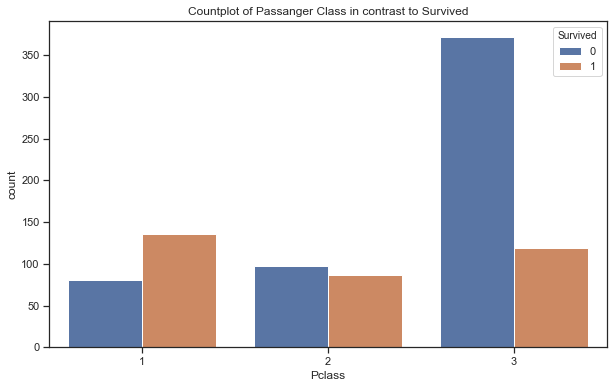

In [17]:
pyplot_options(10, 6)
sns.countplot(x = df_train.loc[:, 'Pclass'], hue = df_train.loc[:, 'Survived'])
plt.title("Countplot of Passanger Class in contrast to Survived")

Conclusion: Class nr 3 has huge impact to Survived target. Class nr 1 has some impact but in difference way tahn nr 3 - in class nr 1 Survived more than half people. 

#### Feature: SibSp

Text(0.5, 1.0, 'Number of sibilings aboard to Titanic in contrast to Survived')

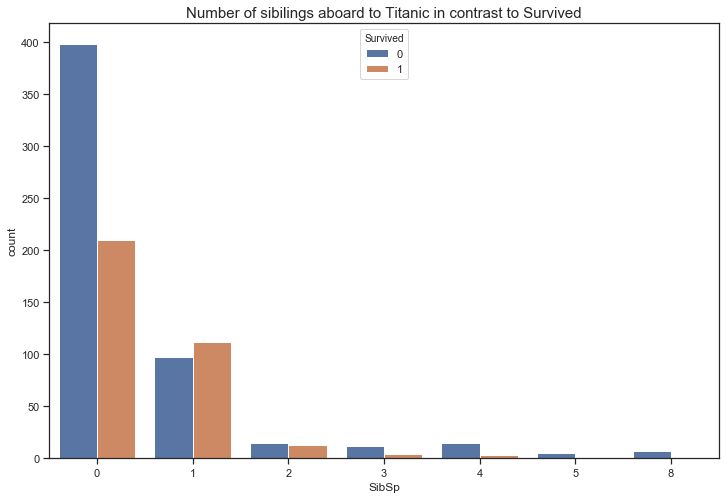

In [18]:
pyplot_options(12, 8)
sns.countplot(data = df_train_new, x='SibSp', hue ='Survived')
plt.title("Number of sibilings aboard to Titanic in contrast to Survived", fontsize=15)

Conclusion: When people didn't have sibilings then probability of survived decreased. 

#### Feature: Parch

Text(0.5, 1.0, 'Number of Parents or Children aboard to Titanic in contrast to Survived')

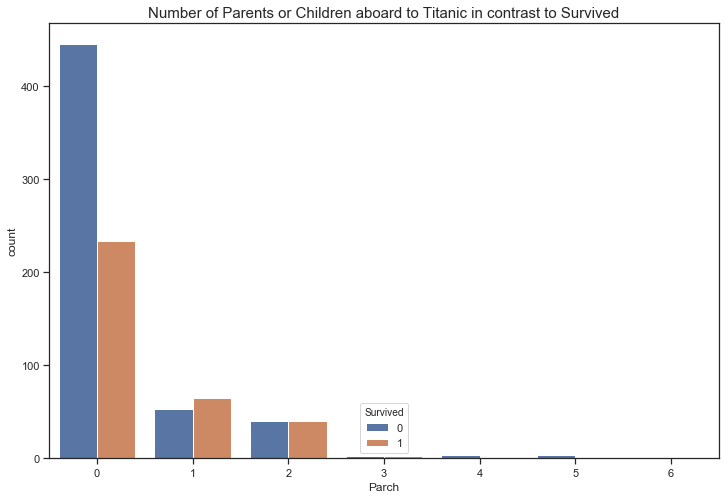

In [19]:
pyplot_options(12, 8)
sns.countplot(data=df_train_new, x = 'Parch', hue = 'Survived')
plt.title("Number of Parents or Children aboard to Titanic in contrast to Survived", fontsize=15)

Conclusion: Parch variable equal to 3, 4, 5 or 6 don't have any influence into the dataset. Parch equal to similar. We see that when passenger didn't have any child or parent survived rarely than passenger who had any close person.

#### Feature: Ticket

In [21]:
ticket_counts = df_train_new.Ticket.value_counts()
ticket_counts = pd.DataFrame({'Ticket':ticket_counts.index, 'PassengerTicket':ticket_counts}).reset_index().drop(['index'],axis=1)

In [22]:
df_train_new = pd.merge(df_train_new, ticket_counts, left_on='Ticket', right_on = 'Ticket', how='left')
df_train_new.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris   1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   0  38.0      1      0   
2                             Heikkinen, Miss. Laina   0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   0  35.0      1      0   
4                           Allen, Mr. William Henry   1  35.0      0      0   

             Ticket     Fare Cabin Embarked  PassengerTicket  
0         A/5 21171   7.2500   NaN        S                1  
1          PC 17599  71.2833   C85        C                1  
2  STON/O2. 3101282   7.9250   NaN        S                1  
3            113803  53.1000  C123        S                2  
4            373450   8.0500   NaN        S                1

Text(0.5, 1.0, 'Number of people on one ticket in contrast to survivors')

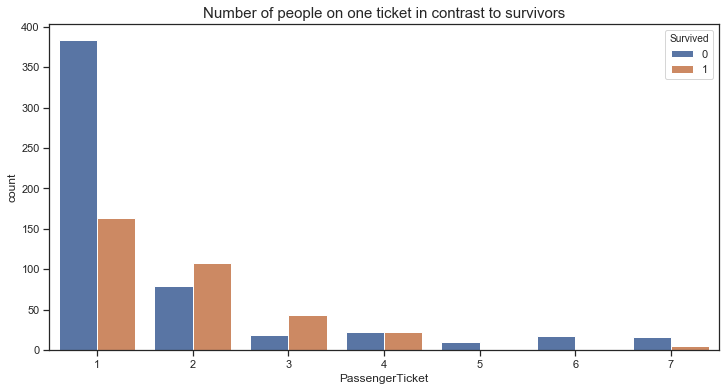

In [24]:
pyplot_options(12, 6)
sns.countplot(data=df_train_new, x="PassengerTicket", hue="Survived")
plt.title("Number of people on one ticket in contrast to survivors", fontsize=15)

Text(0.5, 1.0, 'Number of people on one ticket (greater than 2) in contrast to survivors')

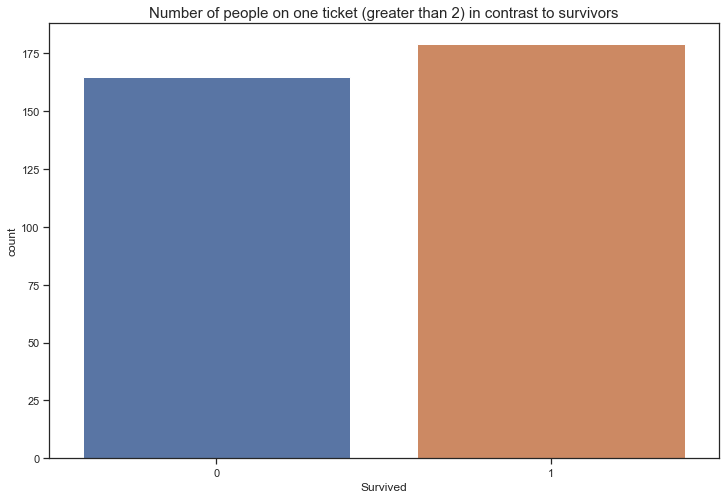

In [29]:
pyplot_options(12, 8)
sns.countplot(data=df_train_new[df_train_new.PassengerTicket >= 2 ], x="Survived")
plt.title("Number of people on one ticket (greater than 2) in contrast to survivors", fontsize=15)

Conclusion: People who traveled with somebody (in the same ticket) had more chance to survived than people who traveled alone.

#### Feature: Fare

Text(0.5, 1.0, 'Boxplot of Fare in contrast to Survived')

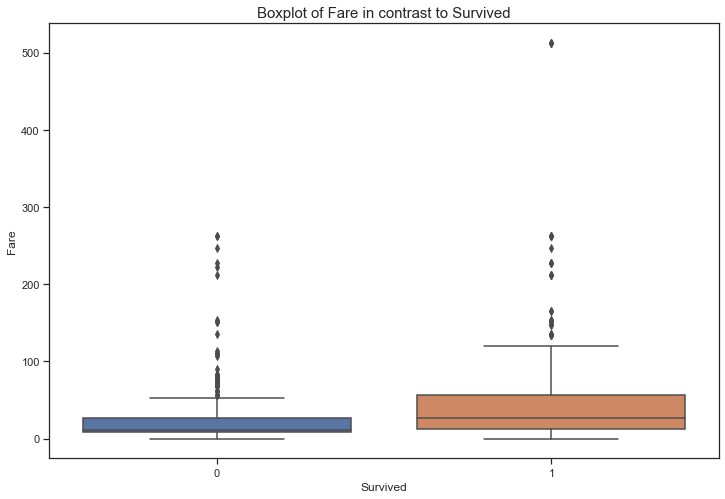

In [31]:
pyplot_options(12, 8)
sns.boxplot(data=df_train_new, x = "Survived", y="Fare", orient="v")
plt.title("Boxplot of Fare in contrast to Survived", fontsize=15)

Text(0.5, 1.0, 'Countplot interval of Fare in contrast to Survived')

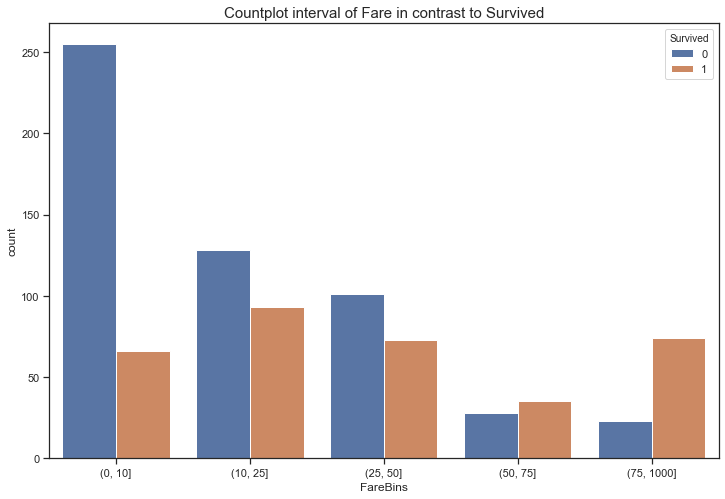

In [32]:
df_train_new['FareBins'] = pd.cut(df_train_new.Fare, bins=[0, 10, 25, 50, 75, 1000])
pyplot_options(12, 8)
sns.countplot(data=df_train_new, x = "FareBins", hue="Survived")
plt.title("Countplot interval of Fare in contrast to Survived", fontsize=15)

Conclusion: Value of fare had big influence of Surivived during Titanic disaster.

#### Feature: Cabin

In [33]:
cabin_counts = df_train_new.Cabin.value_counts()
cabin_counts = pd.DataFrame({'Cabin':cabin_counts.index, 'PassengerCabin':cabin_counts}).reset_index().drop(['index'],axis=1)

In [34]:
df_train_new2 = pd.merge(df_train_new.copy(), cabin_counts, left_on='Cabin', right_on = 'Cabin', how='left')
df_train_new2.PassengerCabin[df_train_new2.PassengerCabin.isna() == True] = 0
df_train_new2.head()

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris   1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   0  38.0      1      0   
2                             Heikkinen, Miss. Laina   0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   0  35.0      1      0   
4                           Allen, Mr. William Henry   1  35.0      0      0   

             Ticket     Fare Cabin Embarked  PassengerTicket  FareBins  \
0         A/5 21171   7.2500   NaN        S                1   (0, 10]   
1          PC 17599  71.2833   C85        C                1  (50, 75]   
2  STON/O2. 3101282   7.9250   NaN        S                1   (0, 10]   
3            113803  53.1000  C123        S                2  (50, 75]   
4            373450   8.0500   NaN        S                1   (0, 10]   

   PassengerCabin  
0             0.0  
1             1.0  
2             0.0  
3             2.0  
4             0.0

Text(0.5, 1.0, 'Number of Passengers who have cabin in contrast to Survived')

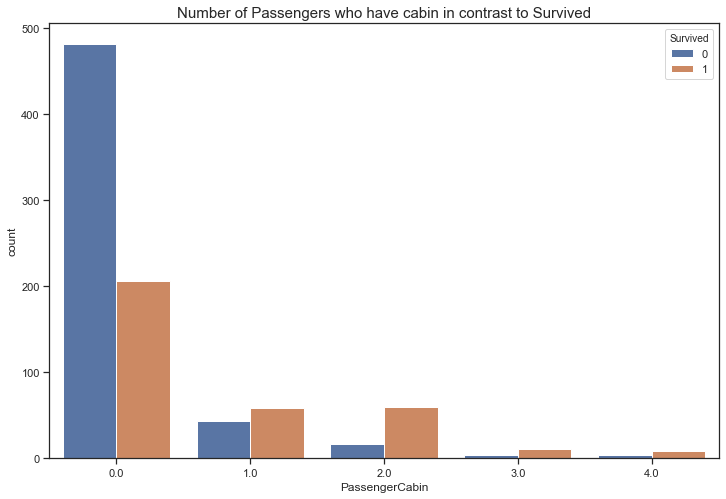

In [36]:
pyplot_options(12, 8)
sns.countplot(data=df_train_new2, x="PassengerCabin", hue="Survived")
plt.title("Number of Passengers who have cabin in contrast to Survived", fontsize=15)

Conclusion: People who didn't have cabin died more often than people who had. 

#### Feature: Embarked

Text(0.5, 1.0, 'Number of Embarked in contrast to Survived')

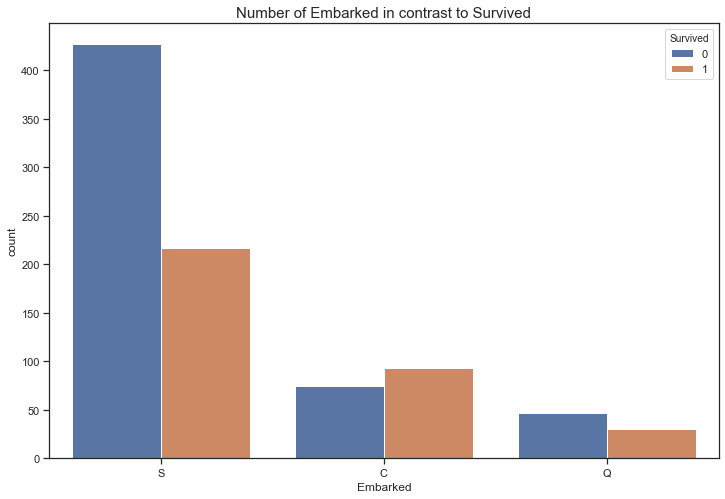

In [37]:
pyplot_options(12, 8)
sns.countplot(data=df_train_new, x = "Embarked", hue="Survived")
plt.title("Number of Embarked in contrast to Survived", fontsize=15)

#### Feature: Name

In [38]:
df_train_new.Name.value_counts()

Becker, Master. Richard F            1
Andrews, Miss. Kornelia Theodosia    1
Moraweck, Dr. Ernest                 1
Lesurer, Mr. Gustave J               1
Walker, Mr. William Anderson         1
                                    ..
Canavan, Miss. Mary                  1
Harper, Mr. Henry Sleeper            1
Windelov, Mr. Einar                  1
Johnson, Mr. Malkolm Joackim         1
Fahlstrom, Mr. Arne Jonas            1
Name: Name, Length: 891, dtype: int64

Conclusion: It will be difficult to show in some plot this variable. I will spend more time analyzing this feature during Feature Engineering part.

## Feature Engineering

#### Set index: PassengerId

In [3]:
def set_index_data(data):
    data.set_index('PassengerId', inplace=True)
    return print("Complete")

#### Convert features

In [4]:
def convert_features(data):
    df = data.copy()
    df['Pclass'] = df['Pclass'].astype('category') 
    df['SibSp'] = df['SibSp'].astype('category')
    df['Parch'] = df['Parch'].astype('category')
    df['Sex'] = df['Sex'].map({'male':1, 'female':0}).astype('category')
    df['Embarked'] = df['Embarked'].astype('category')
    df['Fare'] = df['Fare'].round(2)
    return df

#### Feature: Age

In [5]:
def feature_engineering_agebins(data, bins=[0, 6, 20, 30, 45, 60, 100], inplace=False):
    data['AgeBins']=pd.cut(data.Age, bins=bins, right=False, labels=bins[:-1])
    print("Complete")
    return data

#### Feature: Name

Now let's see on Name feature. We see that there are some names, surnames but also titles like Miss, Mr or Master. May be it will be important for our model. Of course titles like Mr. or Miss. are in Sex variable but Master is something else. Let's try to find there some pattern !!

In [7]:
df_train_new = df_train.copy()

In [8]:
set_index_data(df_train_new)

Complete


In [9]:
df_name = df_train_new.Name.str.split(",", expand=True).rename(columns = lambda x: f"Part_Name_{x+1}")
df_name_2 = df_name.Part_Name_2.str.split(".", expand=True).rename(columns = lambda x: f"Part_Name_{x+1}")
df_name.rename(columns={"Part_Name_1":"Surname", "Part_Name_2":"Title_Name"}, inplace=True)
df_name_2.rename(columns = {"Part_Name_1":"Title", "Part_Name_2":"Surname", "Part_Name_3":"Rest"}, inplace=True)

In [10]:
df_name.head(1)

Surname        Title_Name
PassengerId                          
1            Braund   Mr. Owen Harris

In [11]:
df_name_2.head(1)

Title       Surname  Rest
PassengerId                          
1              Mr   Owen Harris  None

In [12]:
df_name_2.Title.unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

We see that all of this title have whitespaces. Let's remove them.

In [13]:
df_name_2['Title'] = df_name_2.Title.str.strip()
df_name_2['Surname'] = df_name_2.Surname.str.strip()
df_name_2['Rest'] = df_name_2.Rest.str.strip()

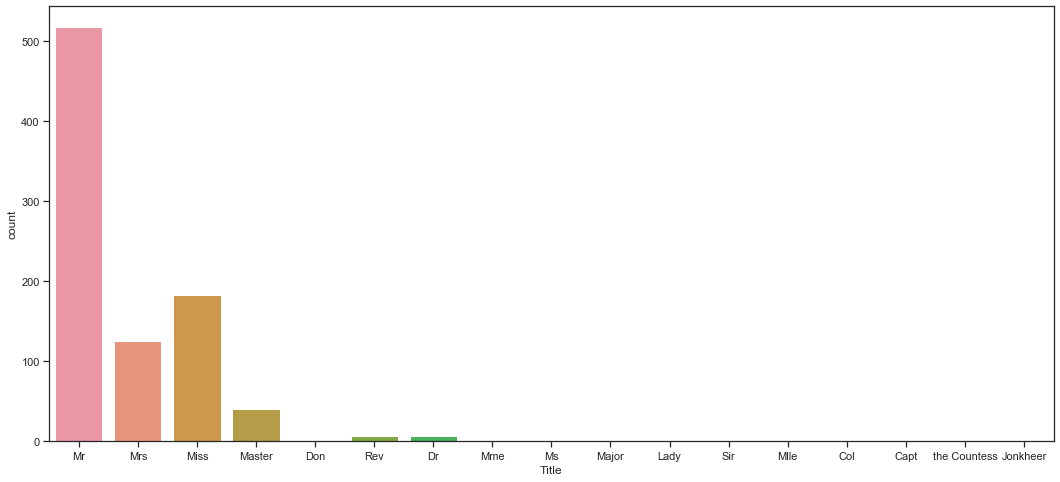

In [17]:
pyplot_options(18, 8)
sns.countplot(data=df_name_2, x = "Title")

We see that on the ship were some people with title different from Mr or Miss. In my opinion titles like: Mr, Miss, Mrs, Master, Ms we can drop. Rest of them may be important in my model. Let's check it in some visualization. 

This feature will be helpful during Imputation process. My dataset have a lot of missing data in Age feature. With title variable I will calculate mean of age feature in all of titles and then I will impute NA values by that average.

In [18]:
normal_titles = ('Mr', 'Miss', 'Mrs', 'Master', 'Ms')
unusual_titles = ('Dr', 'Rev', 'Mlle', 'Col', 'Capt', 'the Countess', 'Mme', 'Lady')

In [19]:
df_plot = pd.merge(df_name_2, pd.DataFrame(df_train_new), how='inner', left_on='PassengerId', right_on='PassengerId') 
df_plot['NormalTitle'] = df_plot.Title.isin(normal_titles).astype(int)

In [20]:
df_plot.head(1)

Title      Surname  Rest  Survived  Pclass  \
PassengerId                                              
1              Mr  Owen Harris  None         0       3   

                                Name   Sex   Age  SibSp  Parch     Ticket  \
PassengerId                                                                 
1            Braund, Mr. Owen Harris  male  22.0      1      0  A/5 21171   

             Fare Cabin Embarked  NormalTitle  
PassengerId                                    
1            7.25   NaN        S            1

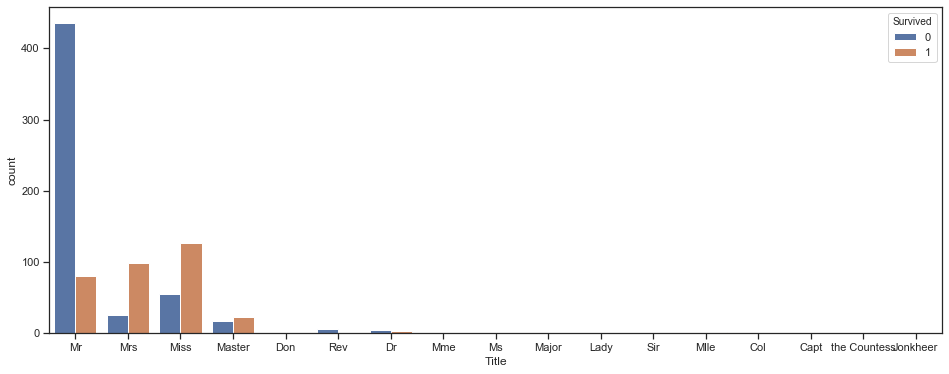

In [21]:
pyplot_options(16, 6)
sns.countplot(x='Title', hue = 'Survived', data = df_plot)

In [22]:
df_plot['Youth'] = df_plot.Title.isin(['Miss', 'Master']).astype(int)

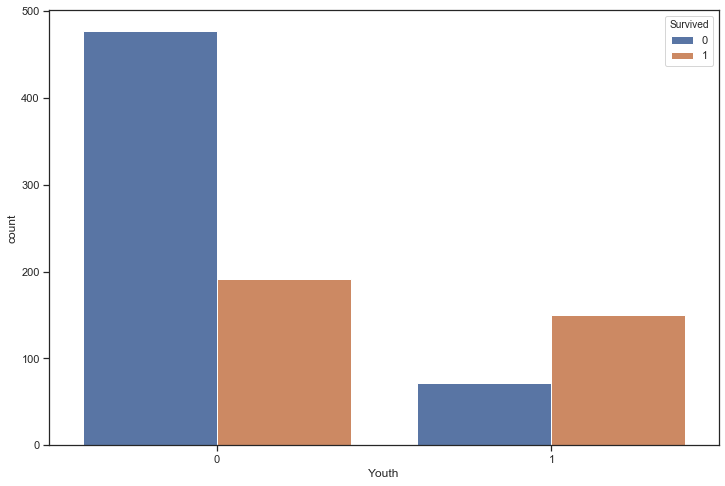

In [23]:
pyplot_options(12, 8)
sns.countplot(x='Youth', hue ='Survived', data=df_plot)

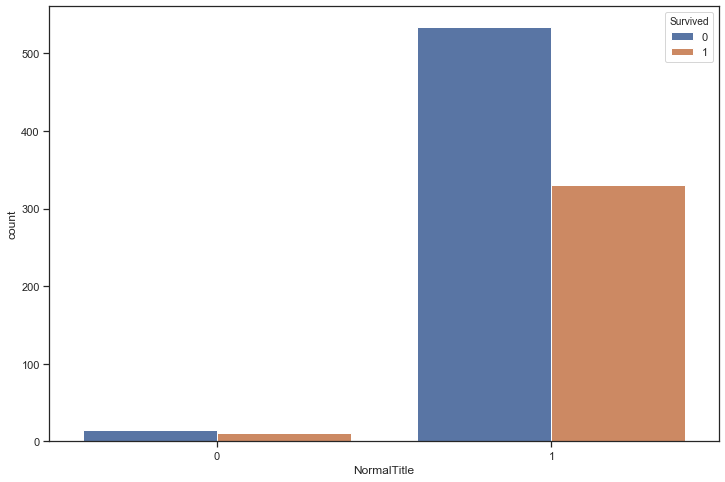

In [24]:
pyplot_options(12, 8)
sns.countplot(x='NormalTitle', hue ='Survived', data=df_plot)

Summarizing column Name isn't so important. I think that the best feature which i can pull from it is feature Youth and NormalTitle like  I show above. Rest of column isn't important - in my opinion of course. Let's create function with all of operation which I've done above.

In [71]:
def feature_engineering_name(data):
    
    # Copy input dataset
    df = data.copy()
    
    # Split Name feature into several columns
    df_name = df.Name.str.split(",", expand=True).rename(columns = lambda x: f"Part_Name_{x+1}")
    df_name_2 = df_name.Part_Name_2.str.split(".", expand=True).rename(columns = lambda x: f"Part_Name_{x+1}")
    
    # Rename new features and remove whitespaces
    df_name_2.rename(columns = {"Part_Name_1":"Title"}, inplace=True)
    df_name_2['Title'] = df_name_2.Title.str.strip()
    
    # Create vector with normal titles
    normal_titles = ('Mr', 'Miss', 'Mrs', 'Master', 'Ms')
    
    # Create new variables 
    df_name_2['NormalTitle'] = df_name_2.Title.isin(normal_titles).astype(int)
    df_name_2['Youth'] = df_name_2['Title'].isin(['Miss', 'Master']).astype(int)
    df_name_2 = df_name_2.loc[:, ('Title', 'NormalTitle', 'Youth')]
    
    df = pd.merge(df, df_name_2, how="inner", on="PassengerId")
    return df

Moreover I create function for imputation Nan values form Age feature. Replacing Nan values by average of Mr, Mrs or Youth title will be ea good idea. More accurate than application of most frequent metric.

In [26]:
df_plot.Age.isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [36]:
age_youth = np.round(df_plot[df_plot.Youth == 1]['Age'].mean())
age_adult = np.round(df_plot[df_plot.Youth == 0]['Age'].mean())
age_mr = np.round(df_plot[df_plot.Title == 'Mr']['Age'].mean())
age_mrs = np.round(df_plot[df_plot.Title == 'Mrs']['Age'].mean())

print("Youth Age:", age_youth)
print("Adult Age:", age_adult)
print("Mr Age:", age_mr)
print("Mrs Age:", age_mrs)

Youth Age: 18.0
Adult Age: 34.0
Mr Age: 32.0
Mrs Age: 36.0


In [31]:
df_plot[(df_plot.Title == 'Mr') & (df_plot.Age.isnull())]  = age_mr

In [32]:
df_plot[(df_plot.Title == 'Mrs') & (df_plot.Age.isnull())]  = age_mrs

In [33]:
df_plot[(df_plot.Youth == 1) & (df_plot.Age.isnull())]  = age_youth

In [37]:
df_plot[(df_plot.Youth == 0) & (df_plot.Age.isnull())]  = age_adult

In [38]:
df_plot.Age.isnull().value_counts()

False    891
Name: Age, dtype: int64

#### Feature: Age

In [114]:
def imputation_age(df):
    age_youth = np.round(df[df.Youth == 1]['Age'].mean())
    age_mr = np.round(df[df.Title == 'Mr']['Age'].mean())
    age_mrs = np.round(df[df.Title == 'Mrs']['Age'].mean())
    age_adult = np.round(df[df.Youth == 0]['Age'].mean())
    
    df.loc[(df.Youth == 1) & (df.Age.isnull()), 'Age']  = age_youth
    df.loc[(df.Title == 'Mr') & (df.Age.isnull()), 'Age']  = age_mr
    df.loc[(df.Title == 'Mrs') & (df.Age.isnull()), 'Age']  = age_mrs
    df.loc[(df.Youth == 0) & (df.Age.isnull()), 'Age']  = age_adult
    return df

#### Feature: Ticket

In [40]:
def feature_passenger_ticket(data):
    ticket_counts = data.Ticket.value_counts()
    ticket_counts = pd.DataFrame({'Ticket':ticket_counts.index, 
                                  'PassengerTicket':ticket_counts}).reset_index().drop(['index'],axis=1) 
    data = pd.merge(data, ticket_counts, left_on='Ticket', right_on = 'Ticket', how='left')
    data['PassengerTicketGT2'] = 0
    data['PassengerTicketGT2'][data.PassengerTicket >= 2] = 1
    print("Complete")
    return data

#### Feature: Cabin

In [41]:
def feature_passenger_cabin(data):
    cabin_counts = data.Cabin.value_counts()
    cabin_counts = pd.DataFrame({'Cabin':cabin_counts.index, 
                                 'PassengerCabin':cabin_counts})\
    .reset_index()\
    .drop(['index'],axis=1)
    data = pd.merge(data, cabin_counts, left_on='Cabin', right_on = 'Cabin', how='left')
    data.PassengerCabin[data.PassengerCabin.isna() == True] = 0
    data['PassengerCabinGT2'] = 0
    data['PassengerCabinGT2'][data.PassengerCabin >= 2] = 1
    print("Complete")
    return data

In [42]:
def feature_engineering_newcabin(data):
    data['NewCabin']=char.ljust(np.array(data.Cabin.replace(np.nan, 'X')).astype(str), width=0)
    print("Complete")
    return data

#### Feature: Fare

In [43]:
def feature_engineering_farebins(data, bins=[0, 10, 25, 50, 75, 1000]):
    data['FareBins']=pd.cut(data.Fare, bins=bins, right=False, labels=bins[:-1])
    print('Complete')
    return data

## Modelling

First one I will split df_train for training and testing datasets. On training dataset I will create new features and build the model and on testing dataset I will use the same functions to create features like on training dataset and check the performence of the model. 

Before split I use PassengerId like index variable. In my opinion PassengerId isn't necessary feature to increase performence the model - it's great feature for index my data.

#### Load dataset

In [340]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sub = pd.read_csv("../data/gender_submission.csv")

#### Train, test split

In [341]:
from sklearn.model_selection import train_test_split

```
X_train = df_train.drop(['Survived'], axis=1)
y_train = df_train.loc[:, 'Survived']
X_test = df_test.copy()
y_test = df_sub.loc[:, 'Survived']
```

In [342]:
X = df_train.copy().drop(['Survived'], axis=1)
y = df_train.loc[:, 'Survived']

In [343]:
np.random.seed(23)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [344]:
print('Shape of training features: ', X_train.shape)
print('Shape of testing features: ', X_test.shape)
print('Shape of training target: ', y_train.shape)
print('Shape of testing target: ', y_test.shape)

Shape of training features:  (623, 11)
Shape of testing features:  (268, 11)
Shape of training target:  (623,)
Shape of testing target:  (268,)


#### Feature Engineering

In [345]:
set_index_data(X_train)
set_index_data(X_test)
set_index_data(df_test)
set_index_data(df_train)

Complete
Complete
Complete
Complete


In [346]:
X_train=convert_features(X_train)
X_test=convert_features(X_test)
df_test = convert_features(df_test)
df_train = convert_features(df_train)

In [347]:
X_train=feature_engineering_name(X_train)
X_test=feature_engineering_name(X_test)
df_test=feature_engineering_name(df_test)
df_train=feature_engineering_name(df_train)

In [348]:
X_train = imputation_age(X_train)
X_test = imputation_age(X_test)
df_train = imputation_age(df_train)
df_test = imputation_age(df_test)

In [349]:
X_train=feature_engineering_agebins(X_train, inplace=False)
X_test=feature_engineering_agebins(X_test, inplace=False)
df_test=feature_engineering_agebins(df_test, inplace=False)
df_train=feature_engineering_agebins(df_train, inplace=False)

Complete
Complete
Complete
Complete


In [350]:
X_train=feature_passenger_ticket(X_train)
X_test=feature_passenger_ticket(X_test)
df_test=feature_passenger_ticket(df_test)
df_train=feature_passenger_ticket(df_train)

Complete
Complete
Complete
Complete


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [351]:
X_train=feature_passenger_cabin(X_train)
X_test=feature_passenger_cabin(X_test)
df_test=feature_passenger_cabin(df_test)
df_train=feature_passenger_cabin(df_train)

Complete
Complete
Complete
Complete


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [352]:
X_train=feature_engineering_newcabin(X_train)
X_test=feature_engineering_newcabin(X_test)
df_test=feature_engineering_newcabin(df_test)
df_train=feature_engineering_newcabin(df_train)

Complete
Complete
Complete
Complete


In [353]:
X_train=feature_engineering_farebins(X_train)
X_test=feature_engineering_farebins(X_test)
df_test=feature_engineering_farebins(df_test)
df_train=feature_engineering_farebins(df_train)

Complete
Complete
Complete
Complete


In [354]:
X_train.head()

Pclass                          Name Sex   Age SibSp Parch        Ticket  \
0      1     Dodge, Master. Washington   1   4.0     0     2         33638   
1      3             Mitkoff, Mr. Mito   1  32.0     0     0        349221   
2      3  Johnson, Miss. Eleanor Ileen   0   1.0     1     1        347742   
3      2         West, Mr. Edwy Arthur   1  36.0     1     2    C.A. 34651   
4      2            Hart, Mr. Benjamin   1  43.0     1     1  F.C.C. 13529   

    Fare Cabin Embarked   Title  NormalTitle  Youth AgeBins  PassengerTicket  \
0  81.86   A34        S  Master            1      1       0                1   
1   7.90   NaN        S      Mr            1      0      30                1   
2  11.13   NaN        S    Miss            1      1       0                3   
3  27.75   NaN        S      Mr            1      0      30                3   
4  26.25   NaN        S      Mr            1      0      30                2   

   PassengerTicketGT2  PassengerCabin  PassengerCabinGT2 NewCabin FareBins  
0                   0             1.0                  0        A       75  
1                   0             0.0                  0        X        0  
2                   1             0.0                  0        X       10  
3                   1             0.0                  0        X       25  
4                   1             0.0                  0        X       25

In [355]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Title', 'NormalTitle', 'Youth', 'AgeBins',
       'PassengerTicket', 'PassengerTicketGT2', 'PassengerCabin',
       'PassengerCabinGT2', 'NewCabin', 'FareBins'],
      dtype='object')

In [356]:
def convert_features_all(data):
    columns_category = ('Pclass', 'SibSp', 'Parch', 'Embarked', 'Title', 'AgeBins', 'PassengerTicket', 'PassengerCabin', 'NewCabin', 'FareBins')
    columns_float = ('Sex', 'Age', 'Fare', 'NormalTitle', 'Youth', 'PassengerTicketGT2', 'PassengerCabinGT2')
    for i in columns_category:
        data[i] = data[i].astype('category')
        
    for i in columns_float:
        data[i] = data[i].astype('float64')
        
    return data

In [357]:
X_train = convert_features_all(X_train)
X_test = convert_features_all(X_test)
df_train = convert_features_all(df_train)
df_test = convert_features_all(df_test)

In [358]:
X_train = X_train.drop(['Name', 'Ticket',  'Cabin', 'TItle'], axis=1)
X_test = X_test.drop(['Name', 'Ticket',  'Cabin', 'TItle'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin', 'TItle'], axis=1)
df_train = df_train.drop(['Name', 'Ticket',  'Cabin', 'TItle'], axis=1)

In [359]:
df_test.dtypes

Pclass                category
Sex                    float64
Age                    float64
SibSp                 category
Parch                 category
Fare                   float64
Embarked              category
Title                 category
NormalTitle            float64
Youth                  float64
AgeBins               category
PassengerTicket       category
PassengerTicketGT2     float64
PassengerCabin        category
PassengerCabinGT2      float64
NewCabin              category
FareBins              category
dtype: object

#### Categorical Variables

In [360]:
from sklearn.impute import SimpleImputer 

In [361]:
def na_values(data, feature):
    return data[data[feature].isna() == True].shape[0]

def number_of_class(data, feature):
    return len(data[feature].unique())

In [362]:
def isin_feature(df_train, df_test, feature):
    unique_values = df_train[feature].unique()
    data_test = df_test.copy()
    data_test.loc[data_test[feature].isin(unique_values), feature] = data_test[feature]
    data_test.loc[~data_test[feature].isin(unique_values), feature] = np.nan
    return data_test

In [363]:
features = ['FareBins', 'AgeBins', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'NewCabin', 'PassengerCabin', 'PassengerCabinGT2', 'PassengerTicket', 'PassengerTicketGT2']
for i in features:
    print("NA values in {} feature: {}".format(i, na_values(df_test, i)))
    print("Number of class in {} feature: {}".format(i, number_of_class(df_test, i)))
    print()

NA values in FareBins feature: 1
Number of class in FareBins feature: 6

NA values in AgeBins feature: 0
Number of class in AgeBins feature: 6

NA values in Pclass feature: 0
Number of class in Pclass feature: 3

NA values in Sex feature: 0
Number of class in Sex feature: 2

NA values in SibSp feature: 0
Number of class in SibSp feature: 7

NA values in Parch feature: 0
Number of class in Parch feature: 8

NA values in Embarked feature: 0
Number of class in Embarked feature: 3

NA values in NewCabin feature: 0
Number of class in NewCabin feature: 8

NA values in PassengerCabin feature: 0
Number of class in PassengerCabin feature: 4

NA values in PassengerCabinGT2 feature: 0
Number of class in PassengerCabinGT2 feature: 2

NA values in PassengerTicket feature: 0
Number of class in PassengerTicket feature: 5

NA values in PassengerTicketGT2 feature: 0
Number of class in PassengerTicketGT2 feature: 2



In [364]:
X_test = isin_feature(X_train, X_test, 'Parch')

In [365]:
df_test = isin_feature(df_train, df_test, 'Parch')

In [366]:
X_train.dtypes

Pclass                category
Sex                    float64
Age                    float64
SibSp                 category
Parch                 category
Fare                   float64
Embarked              category
Title                 category
NormalTitle            float64
Youth                  float64
AgeBins               category
PassengerTicket       category
PassengerTicketGT2     float64
PassengerCabin        category
PassengerCabinGT2      float64
NewCabin              category
FareBins              category
dtype: object

In [367]:
categorical_variables = ('Pclass', 'SibSp', 'Parch', 'Embarked', 'Title', 'AgeBins', 'PassengerTicket', 'PassengerCabin', 'NewCabin', 'FareBins')
categorical_imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_imputer.fit(X_train.loc[:, categorical_variables])
X_train.loc[:, categorical_variables] = categorical_imputer.transform(X_train.loc[:, categorical_variables])
X_test.loc[:, categorical_variables] = categorical_imputer.transform(X_test.loc[:, categorical_variables])
df_test.loc[:, categorical_variables] = categorical_imputer.transform(df_test.loc[:, categorical_variables])
df_train.loc[:, categorical_variables] = categorical_imputer.transform(df_train.loc[:, categorical_variables])

#### One Hot Encoding

In [368]:
print(X_train.Parch.unique())
print(X_test.Parch.unique())
print(df_test.Parch.unique())

[2 0 1 6 4 3 5]
[1 0 2 3 4 5]
[0. 1. 3. 2. 4. 6. 5.]


In [383]:
X_train = convert_features_all(X_train)
X_test = convert_features_all(X_test)
df_train = convert_features_all(df_train)
df_test = convert_features_all(df_test)

In [384]:
X_train.dtypes

Pclass                category
Sex                    float64
Age                    float64
SibSp                 category
Parch                 category
Fare                   float64
Embarked              category
Title                 category
NormalTitle            float64
Youth                  float64
AgeBins               category
PassengerTicket       category
PassengerTicketGT2     float64
PassengerCabin        category
PassengerCabinGT2      float64
NewCabin              category
FareBins              category
dtype: object

In [389]:
df_train.Title.unique()

[Mr, Mrs, Miss, Master, Don, ..., Mlle, Col, Capt, the Countess, Jonkheer]
Length: 17
Categories (17, object): [Mr, Mrs, Miss, Master, ..., Col, Capt, the Countess, Jonkheer]

In [391]:
from sklearn.preprocessing import OneHotEncoder

encoder_features = ['FareBins', 'AgeBins', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'NewCabin', 'PassengerCabin', 'PassengerTicket']
encoder = OneHotEncoder()
encoder.fit(df_train.loc[:, encoder_features])
encoding_features_train=encoder.transform(X_train.loc[:, encoder_features]).toarray()
encoding_features_test=encoder.transform(X_test.loc[:, encoder_features]).toarray()
encoding_features_df_test=encoder.transform(df_test.loc[:, encoder_features]).toarray()
encoding_features_df_train=encoder.transform(df_train.loc[:, encoder_features]).toarray()

In [392]:
X_train.drop(columns=encoder_features, inplace=True)
X_test.drop(columns=encoder_features, inplace=True)
df_test.drop(columns=encoder_features, inplace=True)
df_train.drop(columns=encoder_features, inplace=True)

In [393]:
df_encoding_train = pd.DataFrame(encoding_features_train, index=X_train.index)
df_encoding_train.columns = encoder.get_feature_names(encoder_features)

df_encoding_test = pd.DataFrame(encoding_features_test, index=X_test.index)
df_encoding_test.columns = encoder.get_feature_names(encoder_features)

df_encoding_df_test = pd.DataFrame(encoding_features_df_test, index=df_test.index)
df_encoding_df_test.columns = encoder.get_feature_names(encoder_features)

df_encoding_df_train = pd.DataFrame(encoding_features_df_train, index=df_train.index)
df_encoding_df_train.columns = encoder.get_feature_names(encoder_features)

In [394]:
X_train=pd.concat([X_train, df_encoding_train], join='outer', axis=1, ignore_index=False)
X_test=pd.concat([X_test, df_encoding_test], join='outer', axis=1, ignore_index=False)
df_test=pd.concat([df_test, df_encoding_df_test], join='outer', axis=1, ignore_index=False)
df_train=pd.concat([df_train, df_encoding_df_train], join='outer', axis=1, ignore_index=False)

In [395]:
print("Shape of train data ", X_train.shape)
print("Shape of test data ", X_test.shape)
print("Shape of test data ", df_test.shape)
print("Shape of training data ", df_train.shape)

Shape of train data  (623, 59)
Shape of test data  (268, 59)
Shape of test data  (418, 59)
Shape of training data  (891, 60)


In [396]:
X = df_train.drop(['Survived'], axis=1)
y = df_train.loc[:, 'Survived']

In [397]:
df_train.columns

Index(['Survived', 'Sex', 'Age', 'Fare', 'NormalTitle', 'Youth',
       'PassengerTicketGT2', 'PassengerCabinGT2', 'FareBins_0', 'FareBins_10',
       'FareBins_25', 'FareBins_50', 'FareBins_75', 'AgeBins_0', 'AgeBins_6',
       'AgeBins_20', 'AgeBins_30', 'AgeBins_45', 'AgeBins_60', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'NewCabin_A', 'NewCabin_B', 'NewCabin_C', 'NewCabin_D',
       'NewCabin_E', 'NewCabin_F', 'NewCabin_G', 'NewCabin_T', 'NewCabin_X',
       'PassengerCabin_0.0', 'PassengerCabin_1.0', 'PassengerCabin_2.0',
       'PassengerCabin_3.0', 'PassengerCabin_4.0', 'PassengerTicket_1',
       'PassengerTicket_2', 'PassengerTicket_3', 'PassengerTicket_4',
       'PassengerTicket_5', 'PassengerTicket_6', 'PassengerTicket_7'],
      dtype='object')

## Cross validation for feature elimination

#### Recursive feature elimination

In [398]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [399]:
X_train.shape

(623, 59)

In [400]:
X_train.head()

Sex   Age   Fare  NormalTitle  Youth  PassengerTicketGT2  \
0  1.0   4.0  81.86          1.0    1.0                 0.0   
1  1.0  32.0   7.90          1.0    0.0                 0.0   
2  0.0   1.0  11.13          1.0    1.0                 1.0   
3  1.0  36.0  27.75          1.0    0.0                 1.0   
4  1.0  43.0  26.25          1.0    0.0                 1.0   

   PassengerCabinGT2  FareBins_0  FareBins_10  FareBins_25  ...  \
0                0.0         0.0          0.0          0.0  ...   
1                0.0         1.0          0.0          0.0  ...   
2                0.0         0.0          1.0          0.0  ...   
3                0.0         0.0          0.0          1.0  ...   
4                0.0         0.0          0.0          1.0  ...   

   PassengerCabin_2.0  PassengerCabin_3.0  PassengerCabin_4.0  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   PassengerTicket_1  PassengerTicket_2  PassengerTicket_3  PassengerTicket_4  \
0                1.0                0.0                0.0                0.0   
1                1.0                0.0                0.0                0.0   
2                0.0                0.0                1.0                0.0   
3                0.0                0.0                1.0                0.0   
4                0.0                1.0                0.0                0.0   

   PassengerTicket_5  PassengerTicket_6  PassengerTicket_7  
0                0.0                0.0                0.0  
1                0.0                0.0                0.0  
2                0.0                0.0                0.0  
3                0.0                0.0                0.0  
4                0.0                0.0                0.0  

[5 rows x 59 columns]

In [401]:
X_train.dtypes

Sex                   float64
Age                   float64
Fare                  float64
NormalTitle           float64
Youth                 float64
PassengerTicketGT2    float64
PassengerCabinGT2     float64
FareBins_0            float64
FareBins_10           float64
FareBins_25           float64
FareBins_50           float64
FareBins_75           float64
AgeBins_0             float64
AgeBins_6             float64
AgeBins_20            float64
AgeBins_30            float64
AgeBins_45            float64
AgeBins_60            float64
Pclass_1              float64
Pclass_2              float64
Pclass_3              float64
SibSp_0               float64
SibSp_1               float64
SibSp_2               float64
SibSp_3               float64
SibSp_4               float64
SibSp_5               float64
SibSp_8               float64
Parch_0               float64
Parch_1               float64
Parch_2               float64
Parch_3               float64
Parch_4               float64
Parch_5   

In [402]:
model = SVC(kernel="linear")
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring='accuracy')

rfecv.fit(X_train, y_train)
print("Optimal number of features: %d" % rfecv.n_features_)

Optimal number of features: 21


In [403]:
rfecv_results = pd.DataFrame({'Columns':X_train.columns, 'Ranking':rfecv.ranking_})
rfecv_results[rfecv_results.Ranking == 1]

Columns  Ranking
0                  Sex        1
12           AgeBins_0        1
21             SibSp_0        1
22             SibSp_1        1
23             SibSp_2        1
24             SibSp_3        1
26             SibSp_5        1
27             SibSp_8        1
28             Parch_0        1
29             Parch_1        1
30             Parch_2        1
31             Parch_3        1
32             Parch_4        1
34             Parch_6        1
42          NewCabin_E        1
44          NewCabin_G        1
49  PassengerCabin_2.0        1
50  PassengerCabin_3.0        1
51  PassengerCabin_4.0        1
55   PassengerTicket_4        1
56   PassengerTicket_5        1

In [404]:
feature_selection_array = np.array(rfecv_results[rfecv_results.Ranking == 1].Columns)

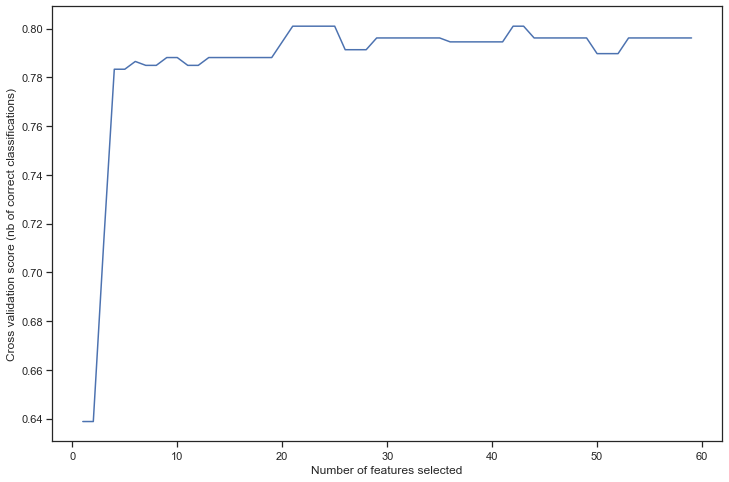

In [405]:
pyplot_options(12, 8)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Model I: Logistic Regression

In [406]:
X_train_new = X_train[feature_selection_array]
X_test_new = X_test[feature_selection_array]

In [408]:
X_train_new.columns

Index(['Sex', 'AgeBins_0', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_6', 'NewCabin_E', 'NewCabin_G', 'PassengerCabin_2.0',
       'PassengerCabin_3.0', 'PassengerCabin_4.0', 'PassengerTicket_4',
       'PassengerTicket_5'],
      dtype='object')

Below I choose the list of features which in my opinion could be important during modelling of Survived from Titanic disaster.

In [410]:
my_features = np.array(['Sex', "AgeBins_0", "AgeBins_6", "AgeBins_20", "AgeBins_30", "AgeBins_45", "AgeBins_60", "Pclass_3", "Parch_0", "PassengerCabinGT2", 
                        "PassengerTicketGT2", "SibSp_0", "SibSp_1"])
X_train_my = X_train[my_features]
X_test_my = X_test[my_features]

In [411]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def logistic_regression_grid_search(X_train, X_test, y_train, y_test):

    grid_param = [
        {'C' : range(0, 11, 1),
        'fit_intercept' : [True, False],
        'penalty' : ['l2'],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
        'class_weight' : ['balanced']},
        {'C' : range(0, 11, 1),
        'fit_intercept' : [True, False],
        'penalty' : ['l1'],
        'solver' : ['liblinear'],
        'class_weight' : ['balanced']},
        {'C' : range(0, 11, 1),
        'fit_intercept' : [True, False],
        'penalty' : ['elasticnet'],
        'solver' : ['saga'],
        'class_weight' : ['balanced'],
        'l1_ratio' : [0.1, 0.3, 0.5, 0.7]}]

    scores = ['accuracy', 'precision', 'recall']
    best_params = []

    for score in scores:
        model_logistic = LogisticRegression()
        model_logistic_gs = GridSearchCV(estimator=model_logistic, param_grid=grid_param, cv=5, scoring=score)
        model_logistic_gs.fit(X_train, y_train)
        print("Score: %s" % score)
        print("Best parameters:", model_logistic_gs.best_params_)
        print()
        print("Training score: %s" % model_logistic_gs.score(X_train, y_train))
        print("Testing score: %s" % model_logistic_gs.score(X_test, y_test))
        best_params = np.append(best_params, model_logistic_gs.best_params_)
    return best_params
    

In [412]:
best_params_all = logistic_regression_grid_search(X_train, X_test, y_train, y_test)

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: accuracy
Best parameters: {'C': 6, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.8378812199036918
Testing score: 0.7873134328358209


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: precision
Best parameters: {'C': 6, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.7620967741935484
Testing score: 0.7327586206896551


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: recall
Best parameters: {'C': 6, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.8181818181818182
Testing score: 0.7657657657657657


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [413]:
best_params_rfecv_features = logistic_regression_grid_search(X_train_new, X_test_new, y_train, y_test)

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: accuracy
Best parameters: {'C': 6, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.8282504012841091
Testing score: 0.8022388059701493


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:53

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: precision
Best parameters: {'C': 6, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.7792792792792793
Testing score: 0.7735849056603774


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: recall
Best parameters: {'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.7532467532467533
Testing score: 0.7387387387387387


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [414]:
best_params_my_features = logistic_regression_grid_search(X_train_my, X_test_my, y_train, y_test)

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: accuracy
Best parameters: {'C': 2, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.812199036918138
Testing score: 0.835820895522388


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: precision
Best parameters: {'C': 2, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

Training score: 0.7522123893805309
Testing score: 0.8130841121495327


C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\s

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ppatrzalek\AppData\Loca

Score: recall
Best parameters: {'C': 4, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'newton-cg'}

Training score: 0.7359307359307359
Testing score: 0.7837837837837838


#### Save results 

In [415]:
import pickle

In [416]:
filename1 = "logistic_reg_my.sav"
filename2 = "logistic_reg_new.sav"
pickle.dump(best_params_rfecv_features, open(filename1, 'wb'))
pickle.dump(best_params_my_features, open(filename2, 'wb'))

## Model II: Random Forest

In [417]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_grid_search(X_train, X_test, y_train, y_test):
    grid_param = [
        {'n_estimators' : range(10, 110, 10),
        'criterion' : ['gini', 'entropy'],
        'min_samples_split' : [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
        'min_samples_split' : [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
        'bootstrap' : [True, False],
        'random_state' : [123],
        'class_weight' : ['balanced', 'balanced_subsample']}]

    scores = ['accuracy']#, 'precision', 'recall']
    best_params = []

    for score in scores:
        random_forest_model = RandomForestClassifier()
        random_forest_model_gs = GridSearchCV(estimator=random_forest_model, param_grid=grid_param, cv=5, scoring=score)
        random_forest_model_gs.fit(X_train, y_train)
        print("Score: %s" % score)
        print("Best parameters:", random_forest_model_gs.best_params_)
        print()
        print("Training score: %s" % random_forest_model_gs.score(X_train, y_train))
        print("Testing score: %s" % random_forest_model_gs.score(X_test, y_test))
        best_params = np.append(best_params, random_forest_model_gs.best_params_)
    return best_params



In [ ]:
random_forest_best_params_features_all = random_forest_grid_search(X_train, X_test, y_train, y_test)

In [418]:
random_forest_best_params_features_new = random_forest_grid_search(X_train_new, X_test_new, y_train, y_test)

Score: accuracy
Best parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 0.01, 'n_estimators': 10, 'random_state': 123}

Training score: 0.8362760834670947
Testing score: 0.8022388059701493


In [419]:
random_forest_best_params_my = random_forest_grid_search(X_train_my, X_test_my, y_train, y_test)

Score: accuracy
Best parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 0.005, 'n_estimators': 20, 'random_state': 123}

Training score: 0.8426966292134831
Testing score: 0.8208955223880597


In [437]:
my_features2 = np.array(['Sex', "Age", "Fare", "Pclass_1", "Pclass_2", "Pclass_3", "Parch_0", "PassengerCabinGT2", 
                        "PassengerTicketGT2", "SibSp_0", "SibSp_1"])
X_train_my2 = X_train[my_features2]
X_test_my2 = X_test[my_features2]
df_test_my2 = df_test[my_features2]


In [436]:
random_forest_best_params_my = random_forest_grid_search(X_train_my2, X_test_my2, y_train, y_test)

Score: accuracy
Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 0.05, 'n_estimators': 40, 'random_state': 123}

Training score: 0.8475120385232745
Testing score: 0.832089552238806


#### Save results

In [420]:
filename1 = "random_forest_model_1.sav"
filename2 = "random_forest_model_2.sav"
pickle.dump(random_forest_best_params_my, open(filename1, 'wb'))
pickle.dump(random_forest_best_params_features_new, open(filename2, 'wb'))

In [684]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

array([{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 0.2, 'n_estimators': 10, 'random_state': 123},
       {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 0.02, 'n_estimators': 80, 'random_state': 123},
       {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 0.1, 'n_estimators': 20, 'random_state': 123}],
      dtype=object)

## Model III: Adaboost

In [45]:
from sklearn.ensemble import AdaBoostClassifier
import time as t

def adaboost_grid_search(X_train, X_test, y_train, y_test):
    grid_param = [
        {'n_estimators' : range(10, 110, 10),
        'learning_rate' : [ 0.01, 0.05, 0.1],
        'algorithm' : ['SAMME', 'SAMME.R']}]

    scores = ['accuracy', 'precision', 'recall']
    best_params = []
    start = t.time()
    
    for score in scores:
        adaboost_model = AdaBoostClassifier()
        adaboost_model_gs = GridSearchCV(estimator=adaboost_model, param_grid=grid_param, cv=5, scoring=score)
        adaboost_model_gs.fit(X_train, y_train)
        print("Score: %s" % score)
        print("Best parameters:", adaboost_model_gs.best_params_)
        print()
        print("Training score: %s" % adaboost_model_gs.score(X_train, y_train))
        print("Testing score: %s" % adaboost_model_gs.score(X_test, y_test))
        print()
        best_params = np.append(best_params, adaboost_model_gs.best_params_)
    end = t.time() - start
    print("Evaluation time: %s" % end)
    return best_params


In [58]:
adaboost_model_features_my = adaboost_grid_search(X_train_my, X_test_my, y_train, y_test)

Score: accuracy
Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

Training score: 0.797752808988764
Testing score: 0.7985074626865671

Score: precision
Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

Training score: 0.7375565610859729
Testing score: 0.7766990291262136

Score: recall
Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 60}

Training score: 0.7056277056277056
Testing score: 0.7207207207207207

Evaluation time: 74.54725909233093


## Model IV: Gradient Boosting

In [423]:
from sklearn.ensemble import GradientBoostingClassifier
import time as t

def gradient_boosting_grid_search(X_train, X_test, y_train, y_test):
    grid_param = [
        {'n_estimators' : range(10, 110, 10),
        'learning_rate' : [ 0.01, 0.05, 0.1]}]

    scores = ['accuracy', 'precision', 'recall']
    best_params = []
    start = t.time()
    
    for score in scores:
        gradient_boosting_model = GradientBoostingClassifier()
        gradient_boosting_model_gs = GridSearchCV(estimator=gradient_boosting_model, param_grid=grid_param, cv=5, scoring=score)
        gradient_boosting_model_gs.fit(X_train, y_train)
        print("Score: %s" % score)
        print("Best parameters:", gradient_boosting_model_gs.best_params_)
        print()
        print("Training score: %s" % gradient_boosting_model_gs.score(X_train, y_train))
        print("Testing score: %s" % gradient_boosting_model_gs.score(X_test, y_test))
        print()
        best_params = np.append(best_params, gradient_boosting_model_gs.best_params_)
    end = t.time() - start
    print("Evaluation time: %s" % end)
    return best_params

In [424]:
gradient_boostnig_model_my = gradient_boosting_grid_search(X_train_my, X_test_my, y_train, y_test)

Score: accuracy
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}

Training score: 0.8459069020866774
Testing score: 0.832089552238806



C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ppatrzalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ppatrzalek\AppData\Loc

Score: precision
Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}

Training score: 0.9669421487603306
Testing score: 0.9193548387096774

Score: recall
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}

Training score: 0.696969696969697
Testing score: 0.7027027027027027

Evaluation time: 26.517837285995483


## XGBoost

In [431]:
X_train_my.dtypes

Sex                   float64
AgeBins_0             float64
AgeBins_6             float64
AgeBins_20            float64
AgeBins_30            float64
AgeBins_45            float64
AgeBins_60            float64
Pclass_3              float64
Parch_0               float64
PassengerCabinGT2     float64
PassengerTicketGT2    float64
SibSp_0               float64
SibSp_1               float64
dtype: object

In [425]:
X_train_my_xgb = X_train_my.copy()
X_test_my_xgb = X_test_my.copy()

for i in X_train_my_xgb.columns:
    X_train_my_xgb[i] = X_train_my_xgb[i].astype('int')
    X_test_my_xgb[i] = X_test_my_xgb[i].astype('int')    

In [426]:
X_train_new_xgb = X_train_new.copy()
X_test_new_xgb = X_test_new.copy()

for i in X_train_new_xgb.columns:
    X_train_new_xgb[i] = X_train_new_xgb[i].astype('int')
    X_test_new_xgb[i] = X_test_new_xgb[i].astype('int')    

In [427]:
X_my_xgb = X_my.copy()

for i in X_my_xgb.columns:
    X_my_xgb[i] = X_my_xgb[i].astype('int')

NameError: name 'X_my' is not defined

In [203]:
X_train_my_xgb.dtypes

Sex                   int32
AgeBins_0.0           int32
AgeBins_6.0           int32
AgeBins_20.0          int32
AgeBins_30.0          int32
AgeBins_45.0          int32
AgeBins_60.0          int32
Pclass_3              int32
Parch_0               int32
PassengerCabinGT2     int32
PassengerTicketGT2    int32
SibSp_0               int32
SibSp_1               int32
dtype: object

In [428]:
from xgboost import XGBClassifier

def xgboosting_grid_search(X_train, X_test, y_train, y_test):
    grid_param = [
        {'n_estimators' : range(10, 110, 10),
        'learning_rate' : [ 0.01, 0.05, 0.1],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'max_depth':[4,6,8,10,12],
        'min_child_weight':[4,5,6],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}]

    scores = ['accuracy']#, 'precision', 'recall']
    best_params = []
    start = t.time()
    
    for score in scores:
        xgb_model = XGBClassifier()
        xgb_model_gs = GridSearchCV(estimator=xgb_model, param_grid=grid_param, cv=5, scoring=score)
        xgb_model_gs.fit(X_train, y_train)
        print("Score: %s" % score)
        print("Best parameters:", xgb_model_gs.best_params_)
        print()
        print("Training score: %s" % xgb_model_gs.score(X_train, y_train))
        print("Testing score: %s" % xgb_model_gs.score(X_test, y_test))
        print()
        best_params = np.append(best_params, xgb_model_gs.best_params_)
    end = t.time() - start
    print("Evaluation time: %s" % end)
    return best_params

In [432]:
xgb_model_my = xgboosting_grid_search(X_train_my, X_test_my, y_train, y_test)

Score: accuracy
Best parameters: {'booster': 'gbtree', 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}

Training score: 0.8282504012841091
Testing score: 0.8246268656716418

Evaluation time: 1795.619918346405


# Submission

#### Best params

In [265]:
X_my=X[my_features]

In [266]:
# Logistic regression
model_lr = LogisticRegression(penalty='l1', C=5.0, fit_intercept=False, solver='liblinear', class_weight='balanced')
model_lr.fit(X_my, y)

LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [268]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=0.01, bootstrap=True, class_weight='balanced_subsample')
model_rf.fit(X_my, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.01, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [269]:
# Adaboost
model_ab = AdaBoostClassifier(algorithm="SAMME.R", learning_rate=0.1, n_estimators=100)
model_ab.fit(X_my, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)

In [270]:
# Gradient boosting
model_gb=GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
model_gb.fit(X_my, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [271]:
#XGBoosting
model_xgb=XGBClassifier(booster='gbtree', gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100)
model_xgb.fit(X_my_xgb, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [272]:
print("Logistic Regression Training Score: {}".format(np.round(model_lr.score(X_my, y), 4)))
print()
print("Random Forest Training Score: {}".format(np.round(model_rf.score(X_my, y), 4)))
print()
print("Adaboost Training Score: {}".format(np.round(model_ab.score(X_my, y), 4)))
print()
print("Gradient boosting Training Score: {}".format(np.round(model_gb.score(X_my, y), 4)))
print()
print("Extreme Gradient Boosting Training Score: {}".format(np.round(model_xgb.score(X_my_xgb, y), 4)))

Logistic Regression Training Score: 0.8159

Random Forest Training Score: 0.8451

Adaboost Training Score: 0.798

Gradient boosting Training Score: 0.8373

Extreme Gradient Boosting Training Score: 0.8283


In [225]:
print("Logistic Regression Training Score: {}".format(np.round(model_lr.score(X_train_my, y_train), 4)))
print("Logistic Regression Test Score: {}".format(np.round(model_lr.score(X_test_my, y_test), 4)))
print()
print("Random Forest Training Score: {}".format(np.round(model_rf.score(X_train_my, y_train), 4)))
print("Random Forest Test Score: {}".format(np.round(model_rf.score(X_test_my, y_test), 4)))
print()
print("Adaboost Training Score: {}".format(np.round(model_ab.score(X_train_my, y_train), 4)))
print("Adaboost Test Score: {}".format(np.round(model_ab.score(X_test_my, y_test), 4)))
print()
print("Gradient boosting Training Score: {}".format(np.round(model_gb.score(X_train_my, y_train), 4)))
print("Gradient boosting Test Score: {}".format(np.round(model_gb.score(X_test_my, y_test), 4)))
print()
print("Extreme Gradient Boosting Training Score: {}".format(np.round(model_xgb.score(X_train_my_xgb, y_train), 4)))
print("Extreme Gradient Boosting Test Score: {}".format(np.round(model_xgb.score(X_test_my_xgb, y_test), 4)))

Logistic Regression Training Score: 0.8154
Logistic Regression Test Score: 0.8358

Random Forest Training Score: 0.8347
Random Forest Test Score: 0.8134

Adaboost Training Score: 0.7978
Adaboost Test Score: 0.7985

Gradient boosting Training Score: 0.8395
Gradient boosting Test Score: 0.8246

Extreme Gradient Boosting Training Score: 0.8283
Extreme Gradient Boosting Test Score: 0.8246


In [87]:
X_train_pred=model_lr.predict(X_train_my)
X_train_pred_proba=model_lr.predict_proba(X_train_my)

([<matplotlib.axis.XTick at 0x1adac580e80>,
 <a list of 10 Text xticklabel objects>)

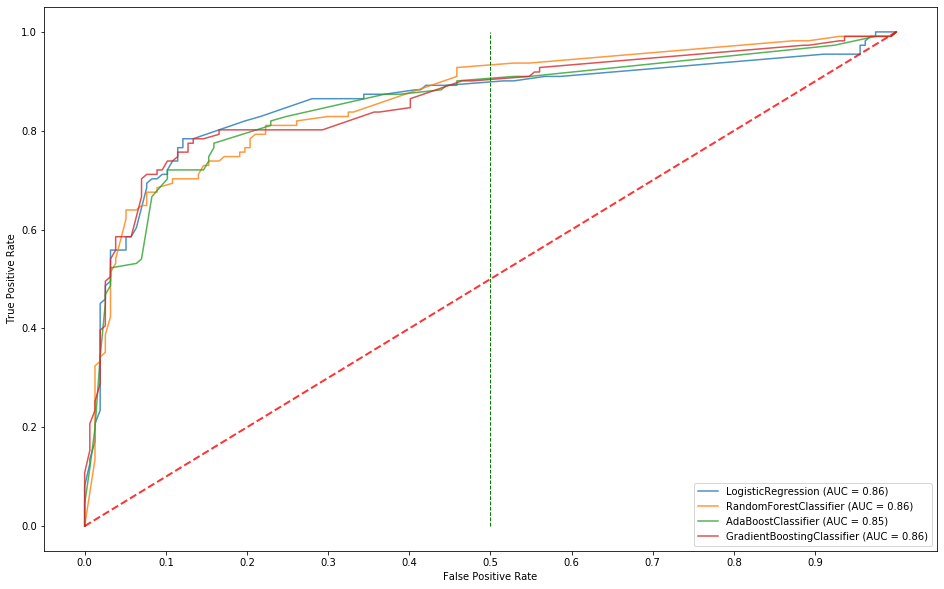

In [134]:
from sklearn.metrics import plot_roc_curve

pyplot_options(16, 10)
ax = plt.gca()
model_lr_roc = plot_roc_curve(model_lr, X_test_my, y_test, ax=ax, alpha=0.8)
model_rf_roc = plot_roc_curve(model_rf, X_test_my, y_test, ax=ax, alpha=0.8)
model_ab_roc = plot_roc_curve(model_ab, X_test_my, y_test, ax=ax, alpha=0.8)
model_gb_roc = plot_roc_curve(model_gb, X_test_my, y_test, ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot([0.5, 0.5], [0, 1], linestyle="--", lw=1, color='g')
plt.xticks(np.arange(0, 1, 0.1))

In [180]:
def predict_proba_score(model, Xtest, ytest, level):
    x_test = Xtest.copy()
    pred_proba=model.predict_proba(x_test)[:, 1]
    pred_proba[pred_proba >= level] = 1
    pred_proba[pred_proba < level] = 0
    score = np.round(np.sum(pred_proba == ytest)/len(ytest), 4)
    return score

In [186]:
import xgboost

## Predict Submission

In [438]:
df_sub_rf2 = random_forest_best_params_my.predict(df_test_my2)

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [275]:
df_sub_rf=model_rf.predict(df_test_my)

In [310]:
df_sub_lr=model_lr.predict(df_test_my)

In [313]:
df_sub_gb=model_gb.predict(df_test_my)

In [296]:
df_sub_rf_model=pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived':df_sub_rf})

In [311]:
df_sub_lr_model=pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived':df_sub_lr})

In [314]:
df_sub_gb_model=pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived':df_sub_gb})

In [315]:
df_sub_rf_model.to_csv("../data/df_sub_rf.csv", columns = ("PassengerId", "Survived"), index=False)
df_sub_lr_model.to_csv("../data/df_sub_lr.csv", columns = ("PassengerId", "Survived"), index=False)
df_sub_gb_model.to_csv("../data/df_sub_gb.csv", columns = ("PassengerId", "Survived"), index=False)